In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import json
import fpfs
import galsim
import astropy.io.fits as pyfits
from configparser import ConfigParser

In [ ]:
def prepare_psf(pscale, seeing, psf_type, outdir):
    psffname = os.path.join(outdir, "psf-%d.fits" % (seeing * 100))
    if psf_type.lower() == "moffat":
        psfInt = galsim.Moffat(
            beta=3.5, fwhm=seeing, trunc=seeing * 4.0
        ).shear(e1=0.02, e2=-0.02)
    else:
        raise ValueError("Only support moffat PSF.")
    psfImg = psfInt.drawImage(nx=45, ny=45, scale=pscale)
    psfImg.write(psffname)
    return psfInt

In [ ]:
Id = 1
config_name = 'config_sim_gal.ini'
cparser = ConfigParser()
cparser.read(config_name)
simname = cparser.get("simulation", "sim_name")
imgdir = cparser.get("simulation", "img_dir")
infname = cparser.get("simulation", "input_name")
scale = cparser.getfloat("survey", "pixel_scale")
image_nx = cparser.getint("survey", "image_nx")
image_ny = cparser.getint("survey", "image_ny")
assert image_ny == image_nx, "'image_nx' must equals 'image_ny'!"
if "basic" in simname or "small" in simname:
    assert image_nx % 256 == 0, "'image_nx' must be divisible by 256 ."
outdir = os.path.join(imgdir, simname)
if not os.path.exists(outdir):
    os.makedirs(outdir, exist_ok=True)

seeing = cparser.getfloat("survey", "psf_fwhm")
psfInt = prepare_psf(scale, seeing, psf_type="moffat", outdir=outdir)

glist = []
if cparser.getboolean("distortion", "test_g1"):
    glist.append("g1")
if cparser.getboolean("distortion", "test_g2"):
    glist.append("g2")
if len(glist) > 0:
    zlist = json.loads(cparser.get("distortion", "shear_z_list"))
    pendList = ["%s-%s" % (i1, i2) for i1 in glist for i2 in zlist]
else:
    # this is for non-distorted image simulation
    pendList = ["g1-1111"]
shear_value = cparser.getfloat("distortion", "shear_value")



variance = 0.01
ud = galsim.UniformDeviate(1)

p2List = ["0000", "2222"]
p1List = ["g1"]
pendList = ["%s-%s" % (i1, i2) for i1 in p1List for i2 in p2List]
pp = pendList[0]
sim_img = fpfs.simutil.make_basic_sim(
    outdir,
    infname,
    psfInt,
    pp,
    Id,
    image_ny,
    image_nx,
    scale,
    shear_value,
    return_array=True
)

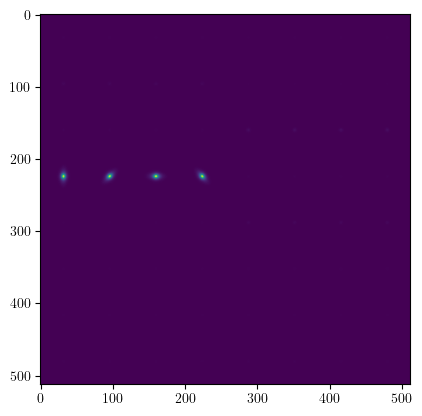

In [22]:
plt.imshow(sim_img)